In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Kinetic Ising Model simulation
Ising model with $N$ spins $\{-1,1\}$, cuplings matrix $J_{ij}$ and external field $h_i$. 

At each time step $\delta t$ each spin $s_i$ flips with a probability 
$$p_{flip} = \gamma \delta t \frac 1 2 [1-s_i(t)\tanh H_i(t)] \quad with \quad
H_i = h_i + \sum_{j \ne i} J_{ij}s_j(t)$$

## Simulation

In [2]:
np.random.seed(123)

N = 10
#########################################
J = np.random.normal(0,1,(N,N))
np.fill_diagonal(J,0)
h = np.random.normal(0,1,N)

p_real = np.concatenate((J.flatten(),h))
##########################################
gamma = 50
steps = 10_000
T = 5
dt = 1/steps
##########################################
S = [-np.ones(N)]
for i in tqdm(range(steps)):
    s = np.copy(S[-1])
    H = h + np.dot(J,s)
    p_flip = gamma*dt*0.5*(1-s*np.tanh(H))
    p = np.random.rand(N)
    s[p<p_flip]*=-1
    S.append(s)
S = np.array(S).T

100%|██████████| 10000/10000 [00:00<00:00, 64738.80it/s]


Text(0.5, 1.0, 'Spin evlolution in time. [$s_i=1$ yellow, $s_i=-1$ blue]')

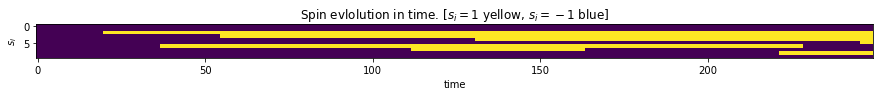

In [3]:
plt.figure(figsize=(15,10))
plt.imshow(S[:,:250])
plt.xlabel('time')
plt.ylabel(r'$s_i$')
plt.title(r'Spin evlolution in time. [$s_i=1$ yellow, $s_i=-1$ blue]')

### NB
$S$ is $S_{it}$ 

## Inference

### Equations

$$
\dot C_{ij} = \delta t ^{-1} \cdot [\langle s_i(t+\delta t)\cdot s_j(t) \rangle_{t} - C_{i,j}] \\
C_{ij} = \langle s_i(t)\cdot s_j(t) \rangle_{t} \\
L = \frac 1 {N_t} \sum_t\sum_i \Big[ h_i\cdot s_i(t) + \big[\sum_{j\ne i} J_{ij}\cdot (\gamma^{-1}\dot{C_{ij}} + C_{ij})\big] - \log \cosh H_i(t)\Big]
$$

### $C$ and $\dot C$

In [4]:
def C_and_Cdot(S,dt):
    # S row is the spins conf
    # S column is the single spin evolution
    N = S.shape[0]
    C = np.zeros((N,N))
    # since C is simmetric we can optimize it ... 
    for i in tqdm(range(N),desc='Computing C'):
        for j in range(N):
            C[i,j] = np.mean(S[i]*S[j])
        
    C_dot = np.zeros((N,N))
    for i in tqdm(range(N),desc='Computing C_dot'):
        for j in range(N):
            C_dot[i,j] = np.mean(S[i,1:]*S[j,:-1])
        
    C_dot -= C
    C_dot /= dt
        
    return C,C_dot        

In [5]:
C,C_dot = C_and_Cdot(S,dt)

Computing C_dot: 100%|██████████| 10/10 [00:00<00:00, 1222.62it/s]


## L
In order to speed up the L function we use matrices.

$equations$

In [6]:
def logcosh(x):
    #the funcion is even, the trick is to avoid e^x
    x = np.abs(x)
    return np.log(1/2) + x + np.log(1 + np.exp(-2*x))

#versione ottimizzata della funzione (e' super piu veloce); sfrutta numpy e le matrici
def L(p,S,C,C_dot,gamma):
    N_t = S.shape[1]
    N = S.shape[0]
    
    # p are the params, S is the spins history
    J = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                    # N vector
    
    #### A #####
    A = np.dot(S.T,h)
    A = np.mean(A)
    
    #### B #####
    B = J*(C_dot/gamma + C)
    B = np.sum(B)
    
    #### C #####
    C = np.tile(h,(N_t,1)).T
    C += np.dot(J,S)
    C = - logcosh(C)
    C = np.mean(np.sum(C,axis=0))
    
    L = A+B+C
    return L

In [7]:
#generating random parameters
np.random.seed(234)
p = np.random.normal(0,1,N*N+N)

In [8]:
L(p,S,C,C_dot,gamma)

-19.47136250646906

## Gradinent
$$
\frac {\partial L}{\partial h_i} = \langle s_i(t) - \tanh{H_i(t)} \rangle_t \\
\frac {\partial L}{\partial J_{ij}} = \gamma ^ {-1} \dot{C_{ij}} + C_{ij} - \langle \tanh{(H_i(t))}s_j(t)  \rangle_t
$$

Also in this case we use matrices to speed up the computation

In [9]:
def grad_L(p,S,C,C_dot,gamma):
    N_t = S.shape[1]
    N = S.shape[0]
    
    # p are the params, S is the spins history
    J = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                    # N vector
    
    #grad wrt h
    H = np.tile(h,(N_t,1)).T
    H += np.dot(J,S)
    G_1 = np.mean(S-np.tanh(H),axis=1)
    
    #grad wrt J
    G_0 = C_dot/gamma + C
    G_0 -= (np.dot(np.tanh(H),S.T))/N_t
    
    return np.concatenate((G_0.flatten(),G_1))
    

In [10]:
grad_L(p,S,C,C_dot,gamma).shape

(110,)

## Test the gradient

In [11]:
param = 1

x = np.ones(N*N + N) + 10
dx = 0.00001
print(grad_L(x,S,C,C_dot,gamma)[param])
y_i = L(x,S,C,C_dot,gamma)
x[param]+=dx
y_f = L(x,S,C,C_dot,gamma)
print((y_f-y_i)/dx)

0.2687051294870492
0.2687034907467023


### Maximization

### SGA with regularization

  2%|▏         | 155/10000 [00:01<01:48, 90.74it/s]


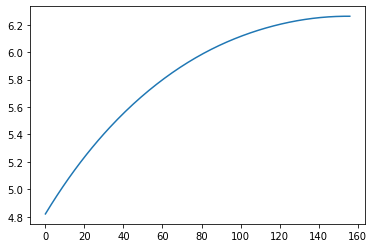

In [16]:
np.random.seed(123)
l_r = 0.01
STEPS = 10000
p_0 = np.random.normal(0,2,N*N+N)
LAMBDA = 0.2

ris = [L(p_0,S,C,C_dot,gamma)]
for i in tqdm(range(STEPS)):
    p_0 += l_r * (grad_L(p_0,S,C,C_dot,gamma) - LAMBDA*(np.abs(p_0)))
    ris.append(L(p_0,S,C,C_dot,gamma))
    if ris[-1]<ris[-2]: break
plt.plot(ris)

## Fancy plots

In [29]:
def plot_coeff(c,N):
    J = c[:N*N].reshape((N,N))
    h = c[N*N:]
    
    plt.imshow(J)
    plt.title(r'$J$')
    plt.figure()
    plt.title(r'$h$')
    plt.imshow([h,])

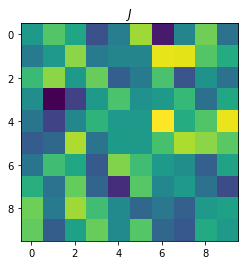

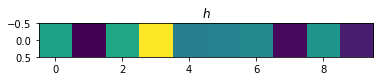

In [30]:
plot_coeff(p_real,N)

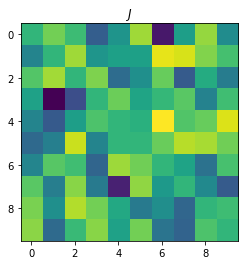

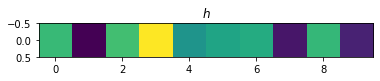

In [31]:
plot_coeff(p_0,N)